1. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
2. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).
3. __Use the__ `Validate` __button in the Assignments tab before submitting__.

__Include comments, derivations, explanations, graphs, etc.__ 

You __work in groups__ (= 3 people). __Write the full name and S/U-number of all team members!__

---

# Assignment 4 (Statistical Machine Learning 2024)
# **Deadline: 21 December 2024**

## Instructions
* Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` __including comments, derivations, explanations, graphs, etc.__ 
Elements and/or intermediate steps required to derive the answer have to be in the report. If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends.
* __Please use LaTeX to write down equations/derivations/other math__! How to do that in Markdown cells can be found [here](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/), a starting point for various symbols is [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).
* Please do __not add new cells__ to the notebook, try to write the answers only in the provided cells. Before you turn the assignment in, make sure everything runs as expected.
* __Use the variable names given in the exercises__, do not assign your own variable names. 
* __Only one team member needs to upload the solutions__. This can be done under the Assignments tab, where you fetched the assignments, and where you can also validate your submissions. Please do not change the filenames of the individual Jupyter notebooks.

For any problems or questions regarding the assignments, ask during the tutorial or send an email to charlotte.cambiervannooten@ru.nl and janneke.verbeek@ru.nl .

## Introduction
Assignment 4 consists of:
1. __Bayesian inference in binary response problem (50 points)__;
2. The EM algorithm for doping detection (50 points);
3. Gibbs sampling and Metropolis-Hastings (50 points);
4. State-Space models (50 points).

## Libraries

Please __avoid installing new packages__, unless really necessary.

In [2]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set fixed random seed for reproducibility
np.random.seed(2022)

## Bayesian inference in binary response (classification) problem (50 points)

In this exercise, we will consider binary logistic regression and perform inference in this model using three different methods: 
1. A point estimate using maximum a posteriori (MAP) solution; 
2. Laplace approximation; 
3. Markov chain Monte Carlo.

## Generate the data

We are generating the data with two classes $t=\{0,1\}$. For simplicity, we have only two attributes $x_{1}$ and $x_{2}$.

In [3]:
num_data = 50

# input values (attributes)
x = np.random.randn(num_data,2)
x[:25,:] += 1.5   # first class (red)
x[25:,:] += -1.5  # second class (blue)

# target values (class indicators)
t = np.zeros((num_data,))
t[25:] += 1

Let's have a look at how the data look like. The first class is represented by the blue circles, the red squares represent the second class.

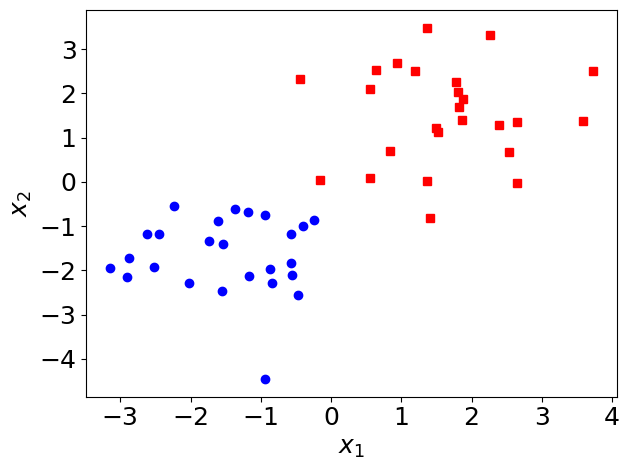

In [4]:
plt.figure()
styles = ['rs','bo']
classes = np.unique(t)
for i,classn in enumerate(classes):
    pos = np.where(t==classn)[0]
    plt.plot(x[pos,0],x[pos,1],styles[i])
    plt.xlabel('$x_{1}$', fontsize=18)
    plt.ylabel('$x_{2}$', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

## Model formulation

You can check for more details lectures on sampling methods and approximate methods. 

Overall, the vector/matrix representation of the data in this problem is given by:
$$
    x_{n}=\begin{pmatrix}x_{n1} \\ x_{n2}\end{pmatrix},  \quad   w=\begin{pmatrix}w_{1} \\ w_{2}\end{pmatrix},  \quad  X=\begin{pmatrix}x_{1}^{T} \\ x_{2}^{T} \\ \vdots \\ x_{N}^{T}\end{pmatrix}.
 $$   

The likelihood:

$$
p(t|X, w) = \prod_{n=1}^{N} P(T_{n}=1|x_{n},w)^{t_{n}} P(T_{n}=0|x_{n}, w)^{1-t_{n}}
     = \prod_{n=1}^{N}\left(\frac{1}{1+\exp(-w^{T}x_{n})} \right)^{t_{n}}\left(\frac{\exp(-w^{T}x_{n})}{1+\exp(-w^{T}x_{n})} \right)^{1-t_{n}}. 
$$    

We assume that the prior is Gaussian, i.e

$$
p(w)=N(0, \sigma^{2}\mathbb{I}),
$$
where $\sigma^{2} = 0.5$.

In this problem, we are interested in finding the posterior distribution of the weights

$$
p(w|t,X) = \frac{p(t|X,w)p(w)}{p(t|X)},
$$

and using it to make the response (class) predictions for a new object $x_{new}$, i.e. we are interested in the following expectation with respect to the posterior


$$
P(t_{new}=1|x_{new}, X, t) = \mathbb{E}_{p(w|X, t, \sigma^{2})}\left\{\frac{1}{1+\exp (-w^{T}x_{new})} \right\}. 
$$

Unfortunately, the posterior distribution and the expectation of the interest with respect to the posterior are not analytically tractable. Thus, we have to use one of the other techniques to evaluate these (MAP, Laplace approximation or sampling methods).

## Part 1  - The inference with MAP solution 

Let us denote $g(w; X, t, \sigma^{2}) = p(t|X,w)p(w)$ which corresponds to denominator of $p(w|t,X)$. As $g(w; X, t, \sigma^{2})$ is proportional to $p(w|t,X)$, the maximum of $g(\cdot)$ will also correspond to the maximum of $p(w|t,X)$. This is much easier since $p(t|X)$ is hard to evaluate. Thus, we can find the maximum a posterior estimate $\hat{w}$ by finding the maximum of $g(w; X, t, \sigma^{2})$. For that, we will use the Newton-Raphson algorithm. 

### The Newton-Raphson algorithm

The Newton-Raphson algorithm for optimization is similar to gradient descent. But unlike with gradient descent, the Newton-Rasphon algorithm also takes into information about the second-order derivatives. When the second derivative is available/easy to compute, the Newton-Raphson algorithm may be preferred due to faster convergence compared to gradient descent. The iteration rule of the Newton-Raphson algorithm reads:
$$
x_{n+1} = x_{n} - \frac{f'(x_{n})}{f''(x_{n})}.
$$

Recall for the binary response model, we have 

$$
\log g(w; X, t) = \sum_{n=1}^{N} \log P(T_{n}=t_{n}|x_{n}, w) +\log p(w|\sigma^{2})\\
= \sum_{n=1}^{N} \log \left[ \left( \frac{1}{1+\exp(-w^{T}x_{n})} \right)^{t_{n}} \left( \frac{\exp(-w^{T}x_{n})}{1+\exp (-w^{T}x_{n})}\right)^{1-t_{n}} \right]\\
+ \log p(w|\sigma^{2})
$$

For simplicity of notation, let us denote 
$$
P_{n} = P(T_{n}=1=w, x_{n}) = \frac{1}{1+\exp(-w^{T}x_{n})}. 
$$
Thus we get (assume that $w$ is D-dimensional):
$$
\log g(w; X, t) = \log p(w|\sigma^{2}) + \sum_{n=1}^{N} \log P_{n}^{t_{n}} + \log (1-P_{n})^{1-t_{n}}\\
=-\frac{D}{2}\log 2\pi -D \log \sigma - \frac{1}{2\sigma}w^{T}w + \sum_{n=1}^{N}\log P_{n} + (1-t_{n})\log(1-P_{n}).
$$
Then for the binary response model, the iteration rule of the Newton-Raphson algorithm is
$$
w_{i+1} = w_{i} -\left(\frac{\partial \log g(w:X,t)}{\partial w \partial w^{T}} \right)^{-1} \frac{\log g(w; X, t)}{\partial w}
$$

For simplicity of notation, let us denote 
$$
P_{n} = P(T_{n}=1=w, x_{n}) = \frac{1}{1+\exp(-w^{T}x_{n})}. 
$$
Thus we get (assume that $w$ is D-dimensional):
$$
\log g(w; X, t) = \log p(w|\sigma^{2}) + \sum_{n=1}^{N} \log P_{n}^{t_{n}} + \log (1-P_{n})^{1-t_{n}}\\
=-\frac{D}{2}\log 2\pi -D \log \sigma^2 - \frac{1}{2\sigma^2}w^{T}w + \sum_{n=1}^{N} t_n \log P_{n} + (1-t_{n})\log(1-P_{n}).
$$

1. Find the vector of partial derivatives (mathematical derivation)
$$
\frac{\partial \log g(w; X, t)}{\partial w}
$$

$$
\frac{\partial \log g(w; X, t)}{\partial w} = -\frac{1}{2\sigma} * 2w + \frac{\partial\sum_{n=1}^{N} t_n \log P_{n} }{\partial w} + \frac{\partial\sum_{n=1}^{N}  (1-t_{n})\log(1-P_{n})}{\partial w}
$$
$$
\frac{\partial\sum_{n=1}^{N} t_n \log P_{n} }{\partial w} = \sum_{n=1}^{N} t_n \frac{\partial \log P_{n} }{\partial w} =  \sum_{n=1}^{N} t_n \frac{1}{P_n} \frac{\partial P_{n} }{\partial w} 
$$
$$
\frac{\partial P_{n} }{\partial w} = \frac{\partial }{\partial w} \frac{1}{1+exp(-w^Tx_n)} = \frac{\partial }{\partial w} (1+exp(-w^Tx_n)^{-1}) = -(1+exp(-w^Tx_n)^{-2})  \frac{\partial }{\partial w} (1+exp(-w^Tx_n)) = -(1+exp(-w^Tx_n)^{-2}) exp(-w^Tx_n) x_n
$$
However, this is sigmoid derivative, which can be rewritten as:
$$
\frac{\partial P_{n} }{\partial w} = -(1+exp(-w^Tx_n)^{-2}) exp(-w^Tx_n) x_n = \frac{1}{1+exp(-w^Tx_n)} ( 1- \frac{1}{1+exp(-w^Tx_n)}) x_n =  P_n(1-P_n)x_n
$$

Then substituting back to the previous equation
$$
\frac{\partial\sum_{n=1}^{N} t_n \log P_{n} }{\partial w} = \sum_{n=1}^{N} t_n \frac{1}{P_{n}} P_n(1-P_n)x_n = \sum_{n=1}^{N} t_n(1-P_n)x_n
$$

Analogically, 
$$
\frac{\partial\sum_{n=1}^{N} (1-t_n) \log (1-P_{n}) }{\partial w} = \sum_{n=1}^{N} (1-t_n) \frac{1}{1-P_n} \frac{\partial (1-P_{n}) }{\partial w} = \sum_{n=1}^{N} (1-t_n) \frac{1}{1-P_n} * (-P_n(1-P_n)x_n) = \sum_{n=1}^{N} (1-t_n)(-P_nx_n)
$$

Then substituting everything into one derivative
$$
\frac{\partial \log g(w; X, t)}{\partial w} = -\frac{w}{\sigma^2} + \sum_{n=1}^{N} t_n(1-P_n)x_n - P_nx_n(1-t_n) = -\frac{w}{\sigma^2} + \sum_{n=1}^{N} x_n(t_n-P_n)
$$


2. Find the Hessian matrix of second derivatives (mathematical derivation)
$$
\frac{\partial^{2} \log g(w; X, t)}{\partial w \partial w^{T}}
$$

To get a second derivative, it is enough to take derivative of a first derivative
$$
\frac{\partial^{2} \log g(w; X, t)}{\partial w \partial w^{T}} = \frac{\partial }{\partial w^{T}} (-\frac{w}{\sigma^2} + \sum_{n=1}^{N} x_n(t_n-P_n))
$$
Then analogically as in question 1:
$$
\frac{\partial^{2} \log g(w; X, t)}{\partial w \partial w^{T}} = -\frac{1}{\sigma^2}I + \sum_{n=1}^{N} \frac{\partial (-P_nx_n)}{\partial w^{T}} = -\frac{1}{\sigma^2}I - \sum_{n=1}^{N} P_n(1-P_n)x_nx_n^T
$$

3. Using the Hessian, conclude whether there is a single optimum and if so, argue whether it is a maximum or a minimum.

Because both Hessian terms are negative, the entire Hessian is negative definite. This leads to a negative eigenvalues, meaning that log(g) is concave. Therefore it has to have a single maximum point.

4. Write down explicitly the iteration rule for the Newton-Raphson algorithm for the binary response problem (i.e., be specific about each term in the iteration rule presented in the explanation above).

$$
w_{i+1} = w_{i} -\left(\frac{\partial \log g(w:X,t)}{\partial w \partial w^{T}} \right)^{-1} \frac{\log g(w; X, t)}{\partial w} = w_{i} - (-\frac{1}{\sigma^2}I - \sum_{n=1}^{N} P_{n, i}(1-P_{n, i})x_nx_n^T)^{-1}(-\frac{w_i}{\sigma^2} + \sum_{n=1}^{N} x_n(t_n-P_{n, i}))
$$

5. Implement the function `grad_function()` which computes the first order gradient for the binary response model:
$$
\frac{\partial \log g(w; X, t)}{\partial w}
$$

In [5]:
def grad_function(w,x,t,sig_sq):
    """
    Compute the gradient of log g(w;X,t)

    Parameters
    ----------
    w : (2,) np.ndarray
        The array containing the weights
    x : (num_data, 2) np.ndarray
        The attributes, where num_data is our sample size
    t : (num_data,1) np.ndarray
        Class labels
    sig_sq : scalar
        Variance of the prior of w
    Returns
    -------
    gradient as (2,) np.ndarray
    
    """

    P = 1/(1+np.exp(-x@w.T))
    x_up = (t-P)@x
    gradient = -w/sig_sq + x_up

    return gradient

In [6]:
"""
Hidden test for grad_function.
"""

'\nHidden test for grad_function.\n'

6. Implement the function `hess_function()` that computes the Hessian matrix of second derivatives
$$
\frac{\partial^{2} \log g(w; X, t)}{\partial w \partial w^{T}}.
$$

In [7]:
def hess_function(w,x,t,sig_sq):
    """
    Compute the Hessian of the second derivatives of log g(w;X,t)

    Parameters
    ----------
    w : (2,) np.ndarray
        The array containing the weights
    x : (num_data, 2) np.ndarray
        The attributes, where num_data is our sample size
    t : (50,1) np.ndarray
        Class labels
    sig_sq : scalar
        Variance of the prior of w
    Returns
    -------
    Hessian matrix as (2,2) np.ndarray
    
    """
    P = 1/(1+np.exp(-x@w.T))
    
    P_term = (P*(1-P)).reshape(50, 1)
    P_sum = (P_term * x).T@x

    Hessian = np.eye(w.shape[0])*-1/sig_sq - P_sum

    return Hessian

In [8]:
"""
Hidden test for hess_function.
"""

'\nHidden test for hess_function.\n'

7. Implement the Newton-Raphson algorithm. 

In [9]:
def newton_raphson(x, t, sig_sq):
    """
    Run Newton-Raphson algorithm 
    
    ----------
    Functions
    Uses grad_function() and hess_function()

    Parameters
    ----------
    x : (num_data, 2) np.ndarray
        The attributes, where num_data is our sample size
    t : (50,) np.ndarray
        Class labels
    sig_sq : scalar
        Variance of the prior of w  
    Returns
    -------
    [w, all_w] list, where w(2, 1) np.ndarray of final values of w
                     and all_w is the list trajectories of w     
    """
    # because we're not given w as input here, then I assume that actual loop of those 10 simulations asked in 8th question, actually has to happen in this function. If w have been given as an input, then I would have called this function for one update step and have a loop in question 8.
    # random initialization of weights
    print(x.shape[1])
    N = 10
    all_w = np.random.uniform(-2, 2, (N+1, x.shape[1]))
    for i in range(N):
        E = grad_function(all_w[i], x, t, sig_sq)
        H = hess_function(all_w[i], x, t, sig_sq)
        all_w[i+1] = all_w[i]-np.linalg.inv(H)@E
    w = all_w[-1]    
    return [w, list(all_w)]

8. Run Newton-Raphson algorithm for 10 iterations. Plot the evolution of $w$ in the optimization procedure. Has the algorithm converged? If not, how many iterations do you need to converge?

2


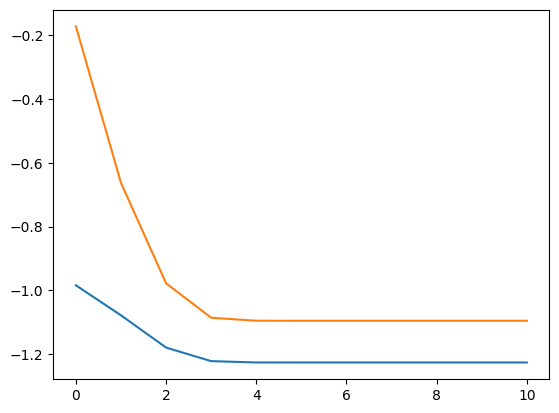

In [10]:
sig_sq = 0.5
# maybe save to array and observe them all?

weights_data = newton_raphson(x, t, sig_sq)
# [w, all_w]
all_w = weights_data[1]
# plot in the optimization procedure? do they mean all w or only last w?
plt.plot(all_w)
plt.show()
    

YOUR ANSWER HERE

9. Show that the decision boundary $P(T=1|x, \hat{w})=0.5$ implies that $\hat{w}^{T}x=0$. 

From the sigmoid formula
$$
P(T=1|x,\hat{w}) = \frac{1}{1+\exp(-\hat{w}^Tx)}
$$
Decision boundary is:
$$
\frac{1}{1+\exp(-\hat{w}^Tx)} = 0.5$
$$
Then
$$
\frac{1}{1+\exp(-\hat{w}^Tx)} = 0.5 \mid \cdot (1+\exp(-\hat{w}^Tx))
$$
$$
1 = 0.5(1+\exp(-\hat{w}^Tx)) 
$$
Then after expaning the brackets and moving numbers to left and keeping variables on the right:
$$
0.5 = 0.5\exp(-\hat{w}^Tx) \mid \cdot 0.5
$$
$$
1 = \exp(-\hat{w}^Tx)
$$
Then taking natural log of both sides
$$
0 = -\hat{w}^Tx \mid \cdot -1
$$

Then we get 
$$
\hat{w}^Tx = 0
$$

10. Using the fact that the decision boundary $P(T=1|x, \hat{w})=0.5$ implies that $\hat{w}^{T}x=0$, use optimal values $\hat{w}$ to plot the decision boundary together on the plot with the original binary response data. Hint: You need to plot the line implied by $\hat{w}^{T}x=0$. 

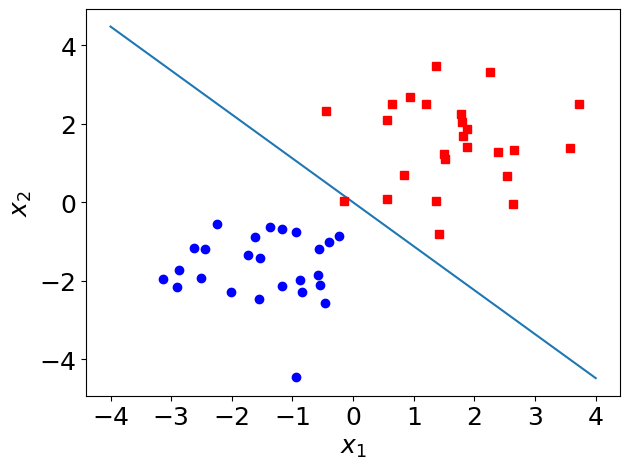

In [11]:
plt.figure()
styles = ['rs','bo']
classes = np.unique(t)

w = weights_data[0]

slope = -w[0] / w[1]

x1 = np.linspace(-4, 4, 100)
x2 = slope * x1
plt.plot(x1, x2)

for i,classn in enumerate(classes):
    pos = np.where(t==classn)[0]
    plt.plot(x[pos,0],x[pos,1],styles[i])
    plt.xlabel('$x_{1}$', fontsize=18)
    plt.ylabel('$x_{2}$', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

11. Finally, plot probability contours of $P(T=1|x, \hat{w})$ using `plt.contour`, as in the example below. Hint: Take grid of points for $x_{1}$ and $x_{2}$ and compute $P$ for different combinations of these points.
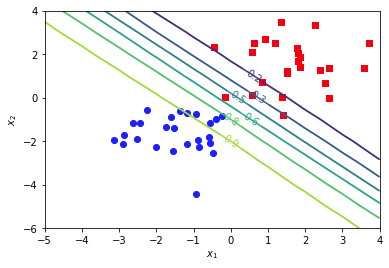


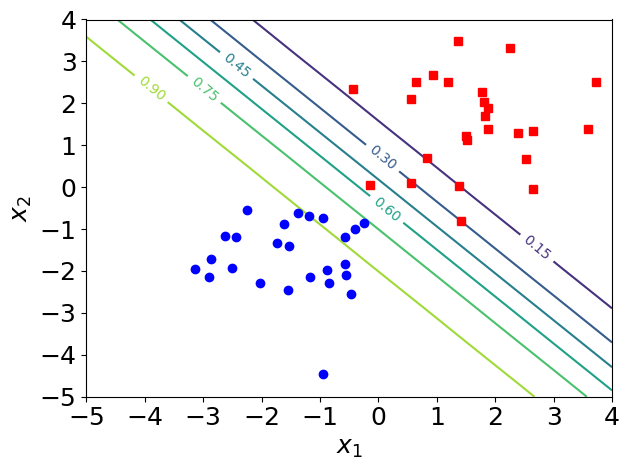

In [16]:
plt.figure()
styles = ['rs','bo']
classes = np.unique(t)
w = weights_data[0]


xx = np.linspace(-5, 4, 50)
X1, X2 = np.meshgrid(xx, xx)

X = np.stack([X1, X2], axis=-1)
P = 1/(1+np.exp(-X@w.T))
cs = plt.contour(X1, X2, P)
# Plot the contours
plt.clabel(cs, inline=True, fontsize=10)

for i,classn in enumerate(classes):
    pos = np.where(t==classn)[0]
    plt.plot(x[pos,0],x[pos,1],styles[i])
    plt.xlabel('$x_{1}$', fontsize=18)
    plt.ylabel('$x_{2}$', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

## Part 2 -- Laplace approximation

Laplace approximation reads (check the lecture slides for more details):

$$
\log g(w; X, t, \sigma^{2})\approx \log g(\hat{w}; X, t, \sigma^{2})-\frac{v}{2}(w-\hat{w}), 
$$
where 
$$
v = - \frac{\partial^{2}\log g(w;X, t, \sigma^{2})}{\partial w \partial w^{T}} \bigg|_{\hat{w}}.
$$

It can be shown that the Laplace approximation to the true posterior $p(w|X, t, \sigma^{2})$ is a Gaussian distribution $N(\mu, \Sigma)$, 

where 

$$\mu=\hat{w}$$ and $$\Sigma^{-1}=-\left(\frac{\partial^{2}\log g(w; X, t, \sigma^{2})}{\partial w \partial w^{T}}\right)\bigg|_{\hat{w}}.$$

Note that $\hat{w}$ -- the value corresponding to the highest value of the posterior -- we already know from the Newton-Raphson optimization (i.e., $\hat{w}$ -- MAP estimate). 

1. Using `hess_function()` defined earlier for the MAP estimation, compute corresponding mean $\mu$ and $\Sigma^{-1}$ (precision) for the Laplace approximation.

In [21]:
w = weights_data[0]
precision = hess_function(w, x, t, sig_sq)
# because it is defined that mu = optimal w, I don't know how can I get mu from hess_function()
mu = w

2. Together with the binary response data, plot twenty decision boundaries sampled from the Laplace approximation, like in the example below. 

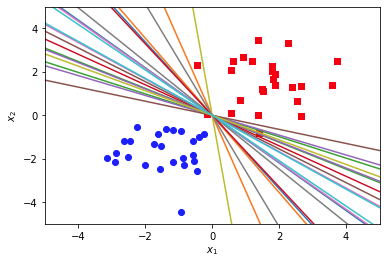

/tmp/ipykernel_5778/4160615820.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mu, cov, size=20)


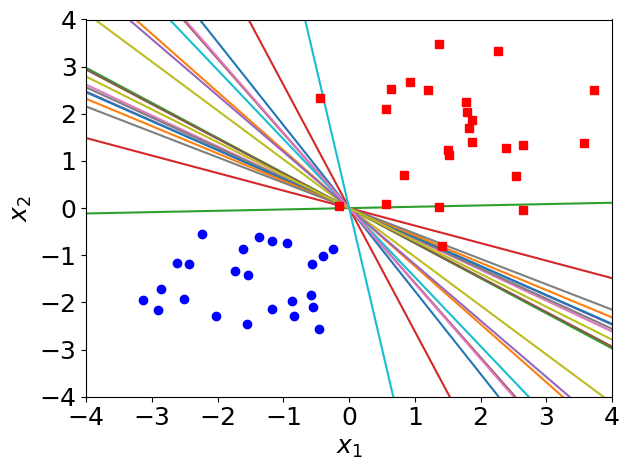

In [27]:
cov = np.linalg.inv(precision)
samples = np.random.multivariate_normal(mu, cov, size=20)
x1 = np.linspace(-4, 4, 100)
plt.figure()
for sample in samples:
    slope = -sample[0] / sample[1]
    x2 = slope * x1
    plt.plot(x1, x2)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

styles = ['rs','bo']
classes = np.unique(t)

for i,classn in enumerate(classes):
    pos = np.where(t==classn)[0]
    plt.plot(x[pos,0],x[pos,1],styles[i])
    plt.xlabel('$x_{1}$', fontsize=18)
    plt.ylabel('$x_{2}$', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

Finally, we are interested in making a prediction of the type
$$
P(T_{new}=1|x_{new}, X, t, \sigma^{2}) = \mathbb{E}\{P(T_{new}=1|x_{new}, w)\}.
$$
The expectation, in this case, requires the computation of an integral over $w$. Despite approximating the posterior, we still cannot simply compute the prediction of this type. Thus, we instead are going to use a Monte Carlo approximation of this quantity:
$$
P(T_{new}=1|x_{new}, X, t, \sigma^{2}) = \frac{1}{N_{s}}\sum_{s=1}^{N_{s}} \frac{1}{1+\exp(-w^{T}_{s}x_{new})}, 
$$
which is possible since we can easily sample from  $N(\mu, \Sigma)$. 

3. Implement Monte Carlo procedure to approximate prediction $P(T_{new}=1|x_{new}, X, t, \sigma^{2})$ and evaluate the probability $P(\cdot)$ in different points of the $(x_{1}, x_{2})$ plane.

In [44]:
def monte_carlo_prediction(n_samples, g_mean, g_cov):
    """
    Run Monte Carlo prediction 

    Parameters
    ----------
    n_samples: integer
        Number of Monte Carlo samples
    g_mean : (2,) np.ndarray
        The mean of the Laplace approximation
    g_cov : (2,2) np.ndarray
        The covariance of the Laplace approximation
    Returns
    -------
    [P, gridX, gridY] list, where P np.ndarray(num_grid_points1,num_grid_points2) 
                            is the probability to be equal to class 1
                            gridX are grid points for the first coordinate np.ndarray(num_grid_points1,num_grid_points2),
                            gridY are grid points for the second coordinate np.ndarray(num_grid_points1,num_grid_points2) 
    """
    weights = np.random.multivariate_normal(g_mean, g_cov, size=n_samples)
    gridX = np.linspace(-5, 4, 50)
    gridY = np.linspace(-5, 4, 50)
    X1, X2 = np.meshgrid(gridX, gridY)
    
    X = np.stack([X1, X2], axis=-1)
    P = 0
    for w in weights:
        P += 1/(1+np.exp(-X@w.T))
    P = P/n_samples
    return [P, gridX, gridY]

4. Run the Monte Carlo algorithm for $N_{s}=1000$ iterations. Plot corresponding contours of the probability of belonging to class 1 computed with a sample-based approximation to $\mathbb{E}_{N(\mu, \Sigma)}\{P(T_{new}=1|x_{new}, w)\}$. Hint: Use `plt.contour`, like in the example below.

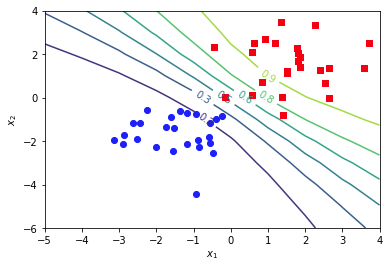

/tmp/ipykernel_5778/394492508.py:20: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  weights = np.random.multivariate_normal(g_mean, g_cov, size=n_samples)


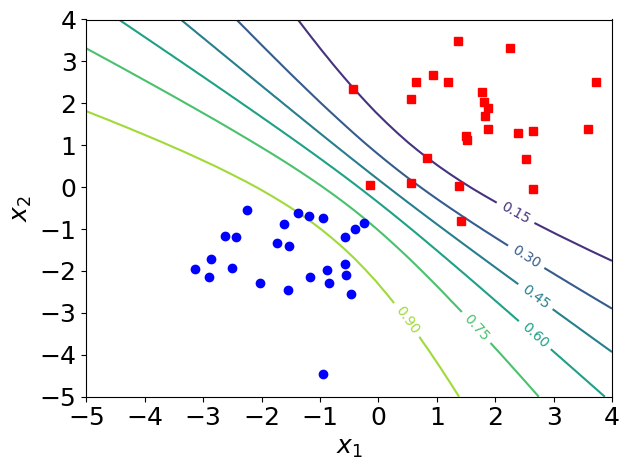

In [45]:
result = monte_carlo_prediction(1000, mu, cov)
[P, gridX, gridY] = result

styles = ['rs','bo']
classes = np.unique(t)
cs = plt.contour(X1, X2, P)
# Plot the contours
plt.clabel(cs, inline=True, fontsize=10)
for i,classn in enumerate(classes):
    pos = np.where(t==classn)[0]
    plt.plot(x[pos,0],x[pos,1],styles[i])
    plt.xlabel('$x_{1}$', fontsize=18)
    plt.ylabel('$x_{2}$', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

## Part 3 - Metropolis-Hastings algorithm for the binary response problem

Generally, the formula for the acceptance probability in the Metropolis-Hastings algorithm is given by:

$$
\alpha(w^{c}, w^{(i)})=\min \left(1, \frac{p(w^{c})}{p(w^{(i)})} \frac{q(w^{(i)}|w^{c})}{q(w^{c}|w^{(i)})}\right),  
$$
where $p(w)$ is our target distribution. 

In this case, it would be more appropriate to use a full notation of $p(w|t, X, \mu_{0}, \sigma^{2}_{0})$ since our target function is the posterior distribution of $w$. Recall that the posterior is equal to the likelihood times the prior. Assume that you are using Gaussian proposal distribution for the Metropolis-Hastings algorithm with mean vector $(0,0)$ and the diagonal covariance matrix, with the diagonal being $(0.5, 0.5)$. 

1. Write down the explicit formula for $p(w^{c})$ and the distribution for $q(w^{(i)}|w^{c})$ in the acceptance probability formula. Is the distribution $q(w^{(i)}|w^{c})$ symmetric?

YOUR ANSWER HERE

2. Using the information from the previous question (i.e., $p(\cdot)$ and the proposal distribution $q(\cdot|\cdot)$), create a function `metropolis_hastings()`. 

In [ ]:
def metropolis_hastings(n_samps, jump_sigma, x, t):
    """
    Metropolis-Hastings algorithm

    Parameters
    ----------
    n_samps: integer
        Number of Metropolis-Hastings samples
    jump_sigma: positive scalar
        Standard deviation of the proposal distribution (we assume it is the same for both parameters)
    x : (num_data, 2) np.ndarray
        The attributes, where num_data is our sample size
    t : (num_data,) np.ndarray
        Class labels
    Returns
    -------
    w_samples (n_samps, 2) np.ndarray
              Metropolis-Hastings samples for (w1, w2)
    
    """
    # YOUR CODE HERE
    raise NotImplementedError()

3. Run Metropolis-Hastings for 1000 iterations and plot 20 random decision boundary samples, like in the example below. 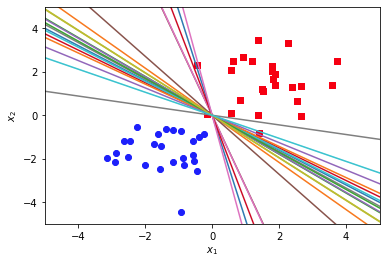

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

4. Similarly to before, plot corresponding contours of the probability of belonging to class 1 computed with the Metropolis-Hastings samples. Hint: Use `plt.contour`, like in the example below.

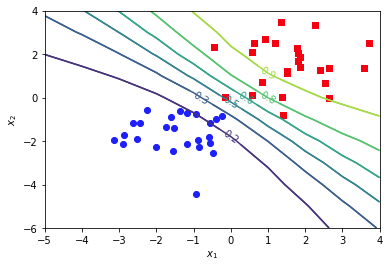

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

5. Comment on the results. How do decision probabilities differ for MAP estimation, Laplace approximation and Metropolis-Hastings? What are the strengths and weaknesses of each of these methods?

YOUR ANSWER HERE